<a href="https://colab.research.google.com/github/JH808/Dokdo_3D/blob/main/dokdo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !wget https://www.python.org/ftp/python/3.10.11/Python-3.10.11.tgz
# !tar xvfz Python-3.10.11.tgz
# !Python-3.10.11/configure
# !make
# !sudo make install

!apt install gdal-bin
!pip install geopandas
!pip install rasterio
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq
!pip install pyvistaqt
!pip install gempy==2.3.0
!pip install gemgis
!pip install trame ipywidgets

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.6.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'
import panel as pn
pn.extension('vtk')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import gempy as gp
import gemgis as gg
from pyvistaqt import BackgroundPlotter
import pyvista
from tqdm import tqdm
import shapely
from shapely import ops, geometry
from typing import Union, List, Tuple, Optional, Sequence, Collection

In [4]:
# dataFrame을 생략 없이 출력하기 위한 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

    구분  등고수치                                UFID   
0  주곡선  5.00  1000037116005F00110000000000000001  \
1  계곡선  0.00  1000037116005F00110000000000000002   
2  계곡선  0.00  1000037116005F00110000000000000003   
3  계곡선  0.00  1000037116005F00110000000000000004   
4  주곡선 10.00  1000037116005F00110000000000000005   

                                            geometry  
0  LINESTRING (277062.808 516076.460, 277063.630 ...  
1  LINESTRING (276955.903 516158.492, 276956.450 ...  
2  LINESTRING (276967.326 516145.577, 276968.796 ...  
3  LINESTRING (276966.550 516162.246, 276967.327 ...  
4  LINESTRING (276823.600 516111.964, 276823.591 ...  


<Axes: >

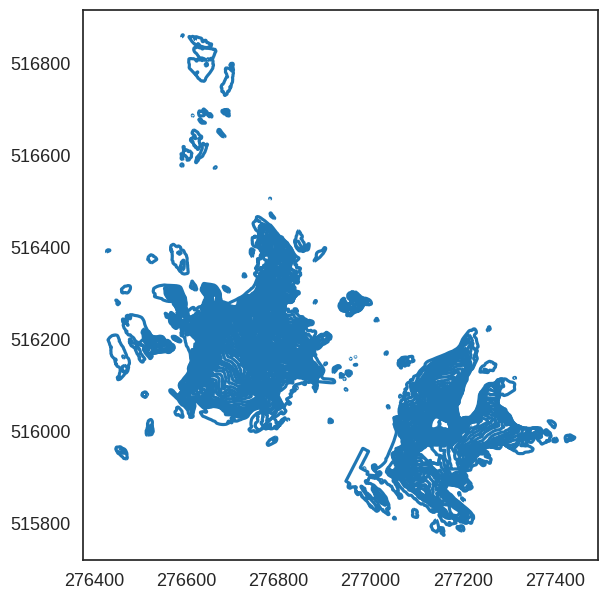

In [5]:
# 등고선의 shape file을 GeoDataFrame으로 변환한다.
EMD = gpd.read_file('/content/N3L_F0010000.shp', encoding='cp949')
print(EMD.head()) # EMD의 초반만 출력

# 등고선을 지층경계선, 단층선 같이 linestrings에서 points로 변환한다.
EMD_xy = gg.vector.extract_xy_linestrings(gdf=EMD)
EMD_with_z = EMD_xy
EMD_with_z['Z'] = EMD_xy['등고수치']

min_x = int(min(EMD_xy['geometry'].x))
max_x = int(max(EMD_xy['geometry'].x))
min_y = int(min(EMD_xy['geometry'].y))
max_y = int(max(EMD_xy['geometry'].y))

EMD.plot()

In [6]:
# 등고선의 고도 정보를 보간시켜서 모든 좌표의 고도 정보를 얻는다.
EMD_raster = gg.vector.interpolate_raster(gdf=EMD,value='등고수치',method='linear',res=15)
# 지질도의 범위를 설정해준 뒤 얻은 고도정보를 tif저장한다.
gg.raster.save_as_tiff(raster=EMD_raster, path='/content/dem_map1.tif', extent=[min_x, max_x, min_y, max_y], crs='EPSG:5188', overwrite_file=True)

EMD_raster = rasterio.open('/content/dem_map1.tif')


Raster successfully saved


In [7]:
# 등고선의 고도 정보를 보간시켜서 모든 좌표의 고도 정보를 얻는다.
EMD_raster_for_save = gg.vector.interpolate_raster(gdf=EMD,value='등고수치',method='linear',res=5)

for i in range(len(EMD_raster_for_save)):
  for j in range(len(EMD_raster_for_save[i])):
    if np.isnan(EMD_raster_for_save[i, j]):
      EMD_raster_for_save[i, j] = 0

# 지질도의 범위를 설정해준 뒤 얻은 고도정보를 tif저장한다.
gg.raster.save_as_tiff(raster=EMD_raster_for_save, path='/content/raster.tif', extent=[min_x, max_x, min_y, max_y], crs='EPSG:5188', overwrite_file=True)

Raster successfully saved


Text(0, 0.5, 'Y [m]')

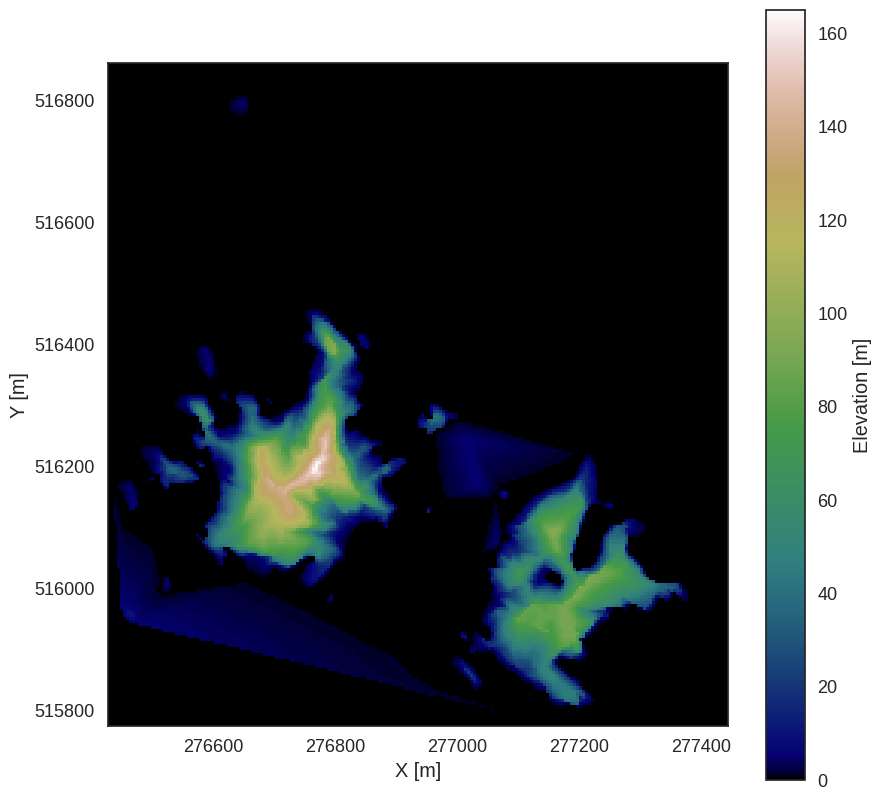

In [8]:
fix, ax = plt.subplots(1, figsize=(10, 10))
im = plt.imshow(EMD_raster_for_save, origin='lower', extent=[min_x, max_x, min_y, max_y], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Elevation [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

['Qst2' 'Qta3' 'Qta2' 'Qt' 'Qet' 'Qdt' 'Qst1' nan]
   fid_1 mapidx mapname lithoidx  comt  type                       geometry   
0   2282   KG31      독도     None  None  지질경계  POINT (276719.778 516186.381)  \
1   2282   KG31      독도     None  None  지질경계  POINT (276719.784 516186.402)   
2   2282   KG31      독도     None  None  지질경계  POINT (276719.807 516186.564)   
3   2282   KG31      독도     None  None  지질경계  POINT (276719.808 516186.701)   
4   2282   KG31      독도     None  None  지질경계  POINT (276719.781 516186.809)   

          X         Y      Z   fid  num  
0 276719.78 516186.38 114.79  Qst2 3.00  
1 276719.78 516186.40 114.79  Qst2 3.00  
2 276719.81 516186.56 114.79  Qst2 3.00  
3 276719.81 516186.70 114.79  Qst2 3.00  
4 276719.78 516186.81 114.79  Qst2 3.00  


<Axes: >

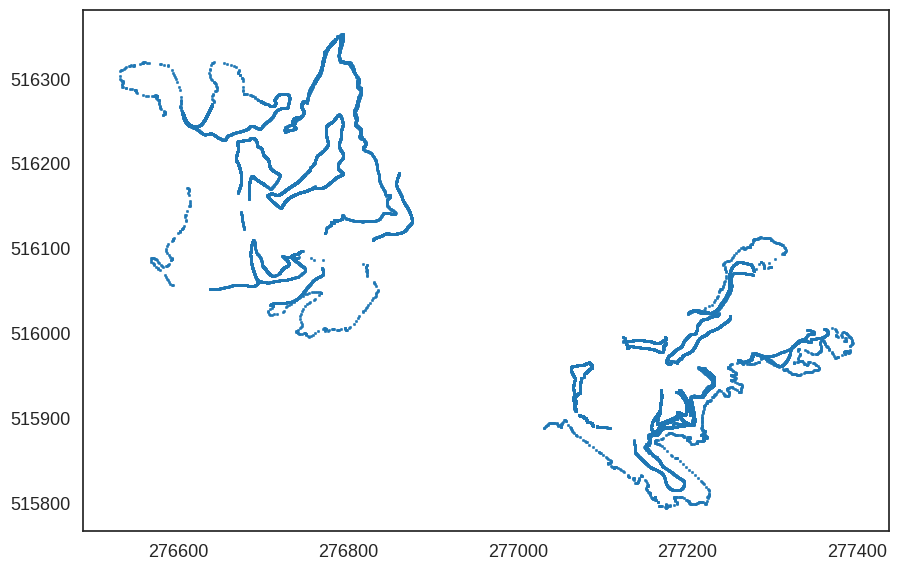

In [9]:
# 지층 경계선의 shape 파일을 GeoDateFrame으로 변환한다.
GEO_xy = gpd.read_file('독도_Geology_50K_Boundary.shp', encoding='utf-8')
# 좌표계를 변경한다.
GEO_xy.crs = 'EPSG:4326'
GEO_xy.geometry = GEO_xy.geometry.to_crs('EPSG:5188')

# 53, 51, (42 + 32 + 89 + 19), 23
GEO_formation_list = GEO_xy['fid_1'].unique()
for i in GEO_formation_list:
  if not i in [2291, 2309, 2362, 2375, 2368, 2327, 2364, 2381, 2220, 2215, 2162, 2152, 2282, 2259, 2336, 2350, 2316, 2347, 2338, 2329, 2132, 2109, 2073, 2071, 2057, 2130, 2045, 2199, 1987, 1995, 1958, 2052, 1960, 2060, 1963, 2139, 2138, 1861, 1942, 1816, 1938, 1857, 1963, 1809, 1827, 1829, 1835, 1799, 1871, 1791, 1770, 1781, 1869, 1812]:
    index = GEO_xy.index[(GEO_xy['fid_1'] == i)]
    GEO_xy = GEO_xy.drop(index)

GEO_xy = GEO_xy.reset_index(drop=True)

# 지층경계선의 각 점에 일치하는 고도 정보를 넣어준다.
GEO_xy_dot = gg.vector.extract_xy_linestrings(gdf=GEO_xy)
GEO = gg.vector.extract_xyz(gdf=GEO_xy_dot, dem=EMD_raster)

###########
GEO.loc[(GEO['fid_1'] == 2291) | (GEO['fid_1'] == 2309), 'fid'] = 'Qta3'
GEO.loc[(GEO['fid_1'] == 2362) | (GEO['fid_1'] == 2375) | (GEO['fid_1'] == 2368), 'fid'] = 'Qta2'
GEO.loc[(GEO['fid_1'] == 2327) | (GEO['fid_1'] == 2364) | (GEO['fid_1'] == 2381), 'fid'] = 'Qst2'
GEO.loc[(GEO['fid_1'] == 2220), 'fid'] = 'Qst1'

GEO.loc[(GEO['fid_1'] == 2215) | (GEO['fid_1'] == 2162) | (GEO['fid_1'] == 2152), 'fid'] = 'Qta2'
GEO.loc[(GEO['fid_1'] == 2282) | (GEO['fid_1'] == 2259), 'fid'] = 'Qst2'
GEO.loc[(GEO['fid_1'] == 2336) | (GEO['fid_1'] ==- 2350), 'fid'] = 'Qst1'
GEO.loc[(GEO['fid_1'] == 2316) | (GEO['fid_1'] == 2347) | (GEO['fid_1'] == 2338) | (GEO['fid_1'] == 2329), 'fid'] = 'Qt'

GEO.loc[(GEO['fid_1'] == 2132) | (GEO['fid_1'] == 2109), 'fid'] = 'Qta2'
GEO.loc[(GEO['fid_1'] == 2073), 'fid'] = 'Qst2'
GEO.loc[(GEO['fid_1'] == 2071), 'fid'] = 'Qst1'
GEO.loc[(GEO['fid_1'] == 2130) | (GEO['fid_1'] == 2045) | (GEO['fid_1'] == 2199), 'fid'] = 'Qt'

GEO.loc[(GEO['fid_1'] == 1930), 'fid'] = 'Qta3'
GEO.loc[(GEO['fid_1'] == 1987) | (GEO['fid_1'] == 1995), 'fid'] = 'Qet'
GEO.loc[(GEO['fid_1'] == 1958) | (GEO['fid_1'] == 2052), 'fid'] = 'Qta2'
GEO.loc[(GEO['fid_1'] == 1960) | (GEO['fid_1'] == 2060), 'fid'] = 'Qst1'
GEO.loc[(GEO['fid_1'] == 1963) | (GEO['fid_1'] == 2139) | (GEO['fid_1'] == 2138), 'fid'] = 'Qdt'

GEO.loc[(GEO['fid_1'] == 1861) | (GEO['fid_1'] == 1942) | (GEO['fid_1'] == 1816), 'fid'] = 'Qta2'
GEO.loc[(GEO['fid_1'] == 1938) | (GEO['fid_1'] == 1857), 'fid'] = 'Qst1'
GEO.loc[(GEO['fid_1'] == 1963) | (GEO['fid_1'] == 1809), 'fid'] = 'Qdt'

GEO.loc[(GEO['fid_1'] == 1827) | (GEO['fid_1'] == 1829), 'fid'] = 'Qta3'
GEO.loc[(GEO['fid_1'] == 1835) | (GEO['fid_1'] == 1799), 'fid'] = 'Qet'
GEO.loc[(GEO['fid_1'] == 1871) | (GEO['fid_1'] == 1791) | (GEO['fid_1'] == 1770) | (GEO['fid_1'] == 1781), 'fid'] = 'Qta2'
GEO.loc[(GEO['fid_1'] == 1869) | (GEO['fid_1'] == 1812), 'fid'] = 'Qst1'
GEO.loc[(GEO['fid_1'] == 1963) | (GEO['fid_1'] == 1809), 'fid'] = 'Qdt'
###########
GEO.loc[(GEO['fid'] == 'Qta3'), 'num'] = 1
GEO.loc[(GEO['fid'] == 'Qta2'), 'num'] = 1
GEO.loc[(GEO['fid'] == 'Qst2'), 'num'] = 1
GEO.loc[(GEO['fid'] == 'Qst1'), 'num'] = 1

GEO.loc[(GEO['fid'] == 'Qta2'), 'num'] = 2
GEO.loc[(GEO['fid'] == 'Qst2'), 'num'] = 2
GEO.loc[(GEO['fid'] == 'Qst1'), 'num'] = 2
GEO.loc[(GEO['fid'] == 'Qt'), 'num'] = 1

GEO.loc[(GEO['fid'] == 'Qta2'), 'num'] = 3
GEO.loc[(GEO['fid'] == 'Qst2'), 'num'] = 3
GEO.loc[(GEO['fid'] == 'Qst1'), 'num'] = 3
GEO.loc[(GEO['fid'] == 'Qt'), 'num'] = 2

GEO.loc[(GEO['fid'] == 'Qta3'), 'num'] = 2
GEO.loc[(GEO['fid'] == 'Qet'), 'num'] = 1
GEO.loc[(GEO['fid'] == 'Qta2'), 'num'] = 4
GEO.loc[(GEO['fid'] == 'Qst1'), 'num'] = 4
GEO.loc[(GEO['fid'] == 'Qdt'), 'num'] = 1

GEO.loc[(GEO['fid'] == 'Qta2'), 'num'] = 5
GEO.loc[(GEO['fid'] == 'Qst1'), 'num'] = 5
GEO.loc[(GEO['fid'] == 'Qdt'), 'num'] = 2

GEO.loc[(GEO['fid'] == 'Qta3'), 'num'] = 3
GEO.loc[(GEO['fid'] == 'Qet'), 'num'] = 2
GEO.loc[(GEO['fid'] == 'Qta2'), 'num'] = 6
GEO.loc[(GEO['fid'] == 'Qst1'), 'num'] = 6
GEO.loc[(GEO['fid'] == 'Qdt'), 'num'] = 3
###########
GEO.loc[(GEO['fid_1'] == 2291) | (GEO['fid_1'] == 2309), 'fid_1'] = 2291
GEO.loc[(GEO['fid_1'] == 2362) | (GEO['fid_1'] == 2375) | (GEO['fid_1'] == 2368), 'fid_1'] = 2362
GEO.loc[(GEO['fid_1'] == 2327) | (GEO['fid_1'] == 2364) | (GEO['fid_1'] == 2381), 'fid_1'] = 2327
GEO.loc[(GEO['fid_1'] == 2220), 'fid_1'] = 2220

GEO.loc[(GEO['fid_1'] == 2215) | (GEO['fid_1'] == 2162) | (GEO['fid_1'] == 2152), 'fid_1'] = 2215
GEO.loc[(GEO['fid_1'] == 2282) | (GEO['fid_1'] == 2259), 'fid_1'] = 2282
GEO.loc[(GEO['fid_1'] == 2336) | (GEO['fid_1'] == 2350), 'fid_1'] = 2336
GEO.loc[(GEO['fid_1'] == 2316) | (GEO['fid_1'] == 2347) | (GEO['fid_1'] == 2338) | (GEO['fid_1'] == 2329), 'fid_1'] = 2316

GEO.loc[(GEO['fid_1'] == 2132) | (GEO['fid_1'] == 2109), 'fid_1'] = 2132
GEO.loc[(GEO['fid_1'] == 2073), 'fid_1'] = 2073
GEO.loc[(GEO['fid_1'] == 2071), 'fid_1'] = 2071
GEO.loc[(GEO['fid_1'] == 2130) | (GEO['fid_1'] == 2045) | (GEO['fid_1'] == 2199), 'fid_1'] = 2130

GEO.loc[(GEO['fid_1'] == 1930), 'fid'] = 1930
GEO.loc[(GEO['fid_1'] == 1987) | (GEO['fid_1'] == 1995), 'fid_1'] = 1987
GEO.loc[(GEO['fid_1'] == 1958) | (GEO['fid_1'] == 2052), 'fid_1'] = 1958
GEO.loc[(GEO['fid_1'] == 1960) | (GEO['fid_1'] == 2060), 'fid_1'] = 1960
GEO.loc[(GEO['fid_1'] == 1963) | (GEO['fid_1'] == 2139) | (GEO['fid_1'] == 2138), 'fid_1'] = 1963

GEO.loc[(GEO['fid_1'] == 1861) | (GEO['fid_1'] == 1942) | (GEO['fid_1'] == 1816), 'fid_1'] = 1861
GEO.loc[(GEO['fid_1'] == 1938) | (GEO['fid_1'] == 1857), 'fid_1'] = 1938
GEO.loc[(GEO['fid_1'] == 1963) | (GEO['fid_1'] == 1809), 'fid_1'] = 1963

GEO.loc[(GEO['fid_1'] == 1827) | (GEO['fid_1'] == 1829), 'fid_1'] = 1827
GEO.loc[(GEO['fid_1'] == 1835) | (GEO['fid_1'] == 1799), 'fid_1'] = 1835
GEO.loc[(GEO['fid_1'] == 1871) | (GEO['fid_1'] == 1791) | (GEO['fid_1'] == 1770) | (GEO['fid_1'] == 1781), 'fid_1'] = 1871
GEO.loc[(GEO['fid_1'] == 1869) | (GEO['fid_1'] == 1812), 'fid_1'] = 1869
GEO.loc[(GEO['fid_1'] == 1963) | (GEO['fid_1'] == 1809), 'fid_1'] = 1963

print(GEO['fid'].unique())
print(GEO.head())
GEO.plot(markersize=3)

[42 23 51 53]


<Axes: >

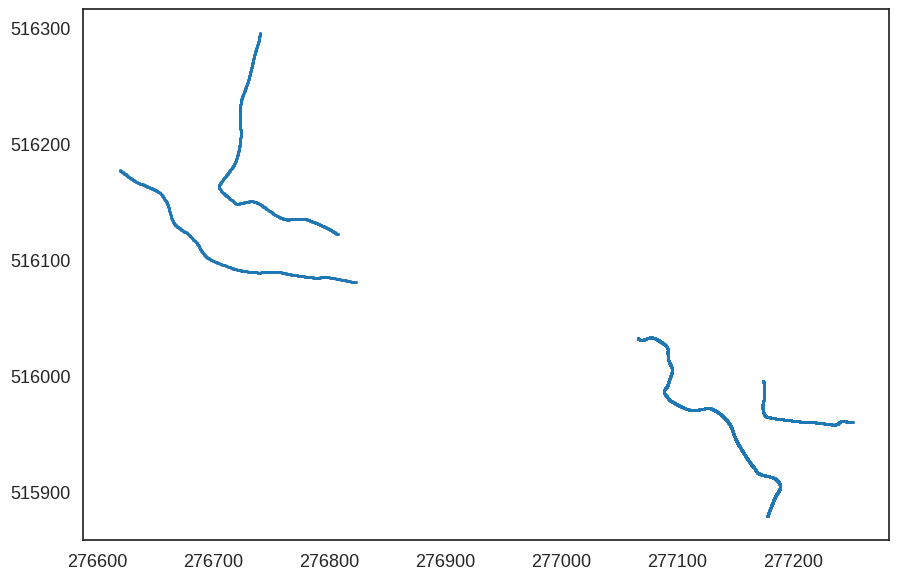

In [10]:
# 단층선의 shape 파일을 GeoDataFrame으로 변환한다.
FAULT_xy = gpd.read_file('/content/독도_Geology_50K_Fault.shp', encoding='utf-8')
# 좌표계를 변경한다.
FAULT_xy.crs = 'EPSG:4326'
FAULT_xy.geometry = FAULT_xy.geometry.to_crs('EPSG:5188')

# 53, 51, (42 + 32 + 89 + 19), 23
FAULT_formation_list = FAULT_xy['fid_1'].unique()
for i in FAULT_formation_list:
  if not i in [53, 51, 42, 32, 89, 19, 23]:
    index = FAULT_xy.index[(FAULT_xy['fid_1'] == i)]
    FAULT_xy = FAULT_xy.drop(index)

FAULT_xy = FAULT_xy.reset_index(drop=True)

# 단층선의 각 점에 일치하는 고도 정보를 넣어준다.
FAULT_xy_dot = gg.vector.extract_xy_linestrings(gdf=FAULT_xy)
FAULT = gg.vector.extract_xyz(gdf=FAULT_xy_dot, dem=EMD_raster)

FAULT.loc[(FAULT['fid_1'] == 32) | (FAULT['fid_1'] == 89) | (FAULT['fid_1'] == 19), 'fid_1'] = 42

print(FAULT['fid_1'].unique())
FAULT.plot(markersize=3)

In [11]:
# 등고수치를 리스트로 정리한다.
z_list = EMD_xy['등고수치'].unique()
z_list = np.delete(z_list, np.where(z_list == 0))
z_list.sort()
z_list = z_list.tolist()

FAULT_fid_list = FAULT['fid_1'].unique()
GEO_fid_list = GEO['fid_1'].unique()
FAULT_fid_list = FAULT_fid_list.tolist()
FAULT_fid_list.sort()
GEO_fid_list = GEO_fid_list.tolist()
GEO_fid_list.sort()
fid_list = FAULT_fid_list + GEO_fid_list
cnt = [[0 for j in range(len(z_list) + 5)] for i in range(len(fid_list) + 10)]

print(fid_list)

error = 2
z = 0

[23, 42, 51, 53, 1827, 1835, 1861, 1869, 1871, 1938, 1958, 1960, 1963, 1987, 2057, 2071, 2073, 2130, 2132, 2215, 2220, 2282, 2291, 2316, 2327, 2336, 2362]


In [12]:
# GEO에 각 지층경계선을 식별할 번호와 등고선과의 교점 정보를 저장할 column을 추가한다.
GEO['formation'] = 0
GEO['id'] = 0
z = 0

loc_formation = 0
loc_id = 0

# 지층경계선과 등고선의 교점을 찾는다.
for index in tqdm(range(len(GEO))):
    for i in z_list:
        if i - error <= GEO.loc[index, 'Z'] <= i + error:
            if i == z:
                break
            else:
                z = i
                loc_formation = fid_list.index(GEO.loc[index, 'fid_1'])
                loc_id = z_list.index(i) + 1

                if cnt[loc_formation][loc_id] < 2:
                    GEO.loc[index, 'formation'] = GEO.loc[index, 'fid_1']
                    GEO.loc[index, 'Z'] = i
                    GEO.loc[index, 'id'] = str(GEO.loc[index, 'fid_1']) + str(i)

                    cnt[loc_formation][loc_id] += 1

                    break

100%|██████████| 20517/20517 [00:03<00:00, 5784.60it/s]


In [13]:
# FAULT에 각 단층선을 식별할 번호와 등고선과의 교점 정보를 저장할 column을 추가한다.
FAULT['formation'] = 0
FAULT['id'] = 0
z = 0

loc_formation = 0
loc_id = 0

# 단층선과 등고선의 교점을 찾는다.
for index in tqdm(range(len(FAULT))):
    for i in z_list:
        if i - error <= FAULT.loc[index, 'Z'] <= i + error:
            if i == z:
                break
            else:
                z = i
                loc_formation = fid_list.index(FAULT.loc[index, 'fid_1'])
                loc_id = z_list.index(i) + 1

                if cnt[loc_formation][loc_id] < 2:
                    FAULT.loc[index, 'formation'] = FAULT.loc[index, 'fid_1']
                    FAULT.loc[index, 'Z'] = i
                    FAULT.loc[index, 'id'] = str(FAULT.loc[index, 'fid_1']) + str(i)

                    cnt[loc_formation][loc_id] += 1

                break

100%|██████████| 3221/3221 [00:00<00:00, 6365.37it/s]


In [14]:
GEO[['formation', 'id']] = GEO[['formation', 'id']].astype(str)
FAULT[['formation', 'id']] = FAULT[['formation', 'id']].astype(str)

GEO_strike_points = GEO[(GEO['formation'] != '0')].reset_index()
FAULT_strike_points = FAULT[FAULT['formation'] != '0'].reset_index()

GEO_strike_points = GEO_strike_points.drop(['index'], axis=1)
FAULT_strike_points = FAULT_strike_points.drop(['index'], axis=1)

for index in range(len(GEO_strike_points)):
  loc_formation = fid_list.index(int(GEO_strike_points.loc[index, 'formation']))
  loc_id = z_list.index(int(GEO_strike_points.loc[index, 'Z'])) + 1
  if cnt[loc_formation][loc_id] < 2:
    GEO_strike_points = GEO_strike_points.drop([index], axis=0)

for index in range(len(FAULT_strike_points)):
  loc_formation = fid_list.index(int(FAULT_strike_points.loc[index, 'formation']))
  loc_id = z_list.index(int(FAULT_strike_points.loc[index, 'Z'])) + 1
  if cnt[loc_formation][loc_id] < 2:
    FAULT_strike_points = FAULT_strike_points.drop([index], axis=0)

contacts = pd.concat([GEO_strike_points, FAULT_strike_points])
GEO_strike_points = GEO_strike_points.reset_index(drop=True)
FAULT_strike_points = FAULT_strike_points.reset_index(drop=True)
contacts = contacts.reset_index(drop=True)

print(contacts)

     fid_1 mapidx mapname lithoidx  comt   type   
0     2282   KG31      독도     None  None   지질경계  \
1     2282   KG31      독도     None  None   지질경계   
2     2282   KG31      독도     None  None   지질경계   
3     2282   KG31      독도     None  None   지질경계   
4     2291   KG31      독도     None  None   지질경계   
5     2291   KG31      독도     None  None   지질경계   
6     2291   KG31      독도     None  None   지질경계   
7     2291   KG31      독도     None  None   지질경계   
8     2291   KG31      독도     None  None   지질경계   
9     2362   KG31      독도     None  None   지질경계   
10    1827   KG31      독도     None  None   지질경계   
11    1861   KG31      독도     None  None   지질경계   
12    1861   KG31      독도     None  None   지질경계   
13    2316   KG31      독도     None  None   지질경계   
14    2362   KG31      독도     None  None   지질경계   
15    2362   KG31      독도     None  None   지질경계   
16    2362   KG31      독도     None  None   지질경계   
17    2362   KG31      독도     None  None   지질경계   
18    2362   KG31      독도     N

In [15]:
# 찾은 교점들을 기반으로 주향선을 계산하여 저장한다.

exist_formation_list = contacts['formation'].unique()

FAULT_strike = gg.vector.create_linestring_gdf(gdf=contacts[contacts['formation'] == str(exist_formation_list[0])])
FAULT_strike = FAULT_strike.drop(FAULT_strike.index[:], axis=0)
GEO_strike = FAULT_strike.copy()

contacts_used = contacts[contacts['formation'] == str(exist_formation_list[0])]
contacts_used = contacts_used.drop(contacts_used.index[:], axis=0)
print(contacts_used)

for i in tqdm(exist_formation_list):
  contacts_used = pd.concat([contacts_used, contacts[contacts['formation'] == i]]).reset_index(drop=True)
  temp_strike = gg.vector.create_linestring_gdf(gdf=contacts[contacts['formation'] == i])
  if (temp_strike['type'].unique()[0] == '단층') or (temp_strike['type'].unique()[0] == '추정단층'):
    FAULT_strike = pd.concat([FAULT_strike, temp_strike]).reset_index(drop=True)
  else:
    GEO_strike = pd.concat([GEO_strike, temp_strike]).reset_index(drop=True)


strike = pd.concat([FAULT_strike, GEO_strike]).reset_index(drop=True)
strike = strike.drop(['index'], axis=1)



Empty GeoDataFrame
Columns: [fid_1, mapidx, mapname, lithoidx, comt, type, geometry, X, Y, Z, fid, num, formation, id, layer, typeno, dipazi]
Index: []


100%|██████████| 24/24 [00:01<00:00, 13.50it/s]


In [16]:
strike[['id']] = strike[['id']].astype(float)
GEO_strike[['id']] = GEO_strike[['id']].astype(float)
FAULT_strike[['id']] = FAULT_strike[['id']].astype(float)

strike_formation_list = strike['formation'].unique()

for i in strike_formation_list:
  present_strike = strike[strike['formation'] == i]
  present_index_list = strike.index[(strike['formation'] == i)]
  length = len(present_strike)

  if len(present_index_list) == 0:
    continue

  index_strike_start = present_index_list[0]
  index_strike_end = present_index_list[-1]

  if length > 2:
    strike = strike.drop(labels=range(index_strike_start + 2, index_strike_end + 1), axis=0)
  elif length < 2:
    strike = strike.drop(index_strike_start, axis=0)

strike = strike.reset_index(drop=True)
print(strike)

    fid_1 mapidx mapname lithoidx  comt   type         X         Y      Z   
0      42   KG31      독도      NaN  None     단층 277091.41 515991.25  20.00  \
1      42   KG31      독도      NaN  None     단층 277183.13 515893.17  35.00   
2      23   KG31      독도      NaN  None     단층 277233.40 515957.94  45.00   
3      23   KG31      독도      NaN  None     단층 277174.77 515982.69  65.00   
4      51   KG31      독도      NaN  None     단층 276769.96 516086.74  50.00   
5      51   KG31      독도      NaN  None     단층 276724.79 516090.49 105.00   
6      53   KG31      독도      NaN  None     단층 276807.23 516121.76  25.00   
7      53   KG31      독도      NaN  None     단층 276789.22 516131.38  45.00   
8    2282   KG31      독도     None  None   지질경계 276785.54 516132.84  45.00   
9    2282   KG31      독도     None  None   지질경계 276783.10 516131.81  60.00   
10   2291   KG31      독도     None  None   지질경계 276784.93 516253.54 125.00   
11   2291   KG31      독도     None  None   지질경계 276769.98 516214.60 130.00   

In [17]:
contacts = contacts.drop(contacts.index[:], axis=0)

for i in range(len(strike)):
  f = strike.loc[i, 'formation']
  z = strike.loc[i, 'Z']
  point = contacts_used[(contacts_used['formation'] == f) & (contacts_used['Z'] == z)]
  contacts = pd.concat([contacts, point]).reset_index(drop=True)

print(contacts)

    fid_1 mapidx mapname lithoidx  comt   type                       geometry   
0      42   KG31      독도      NaN  None     단층  POINT (277091.412 515991.247)  \
1      42   KG31      독도      NaN  None     단층  POINT (277090.479 515982.531)   
2      42   KG31      독도      NaN  None     단층  POINT (277183.130 515893.168)   
3      42   KG31      독도      NaN  None     단층  POINT (277084.007 516030.414)   
4      23   KG31      독도      NaN  None     단층  POINT (277233.398 515957.937)   
5      23   KG31      독도      NaN  None     단층  POINT (277173.779 515995.646)   
6      23   KG31      독도      NaN  None     단층  POINT (277174.768 515982.686)   
7      23   KG31      독도      NaN  None     단층  POINT (277173.807 515995.410)   
8      51   KG31      독도      NaN  None     단층  POINT (276769.960 516086.738)   
9      51   KG31      독도      NaN  None     단층  POINT (276649.993 516159.983)   
10     51   KG31      독도      NaN  None     단층  POINT (276724.792 516090.492)   
11     51   KG31      독도    

<Axes: >

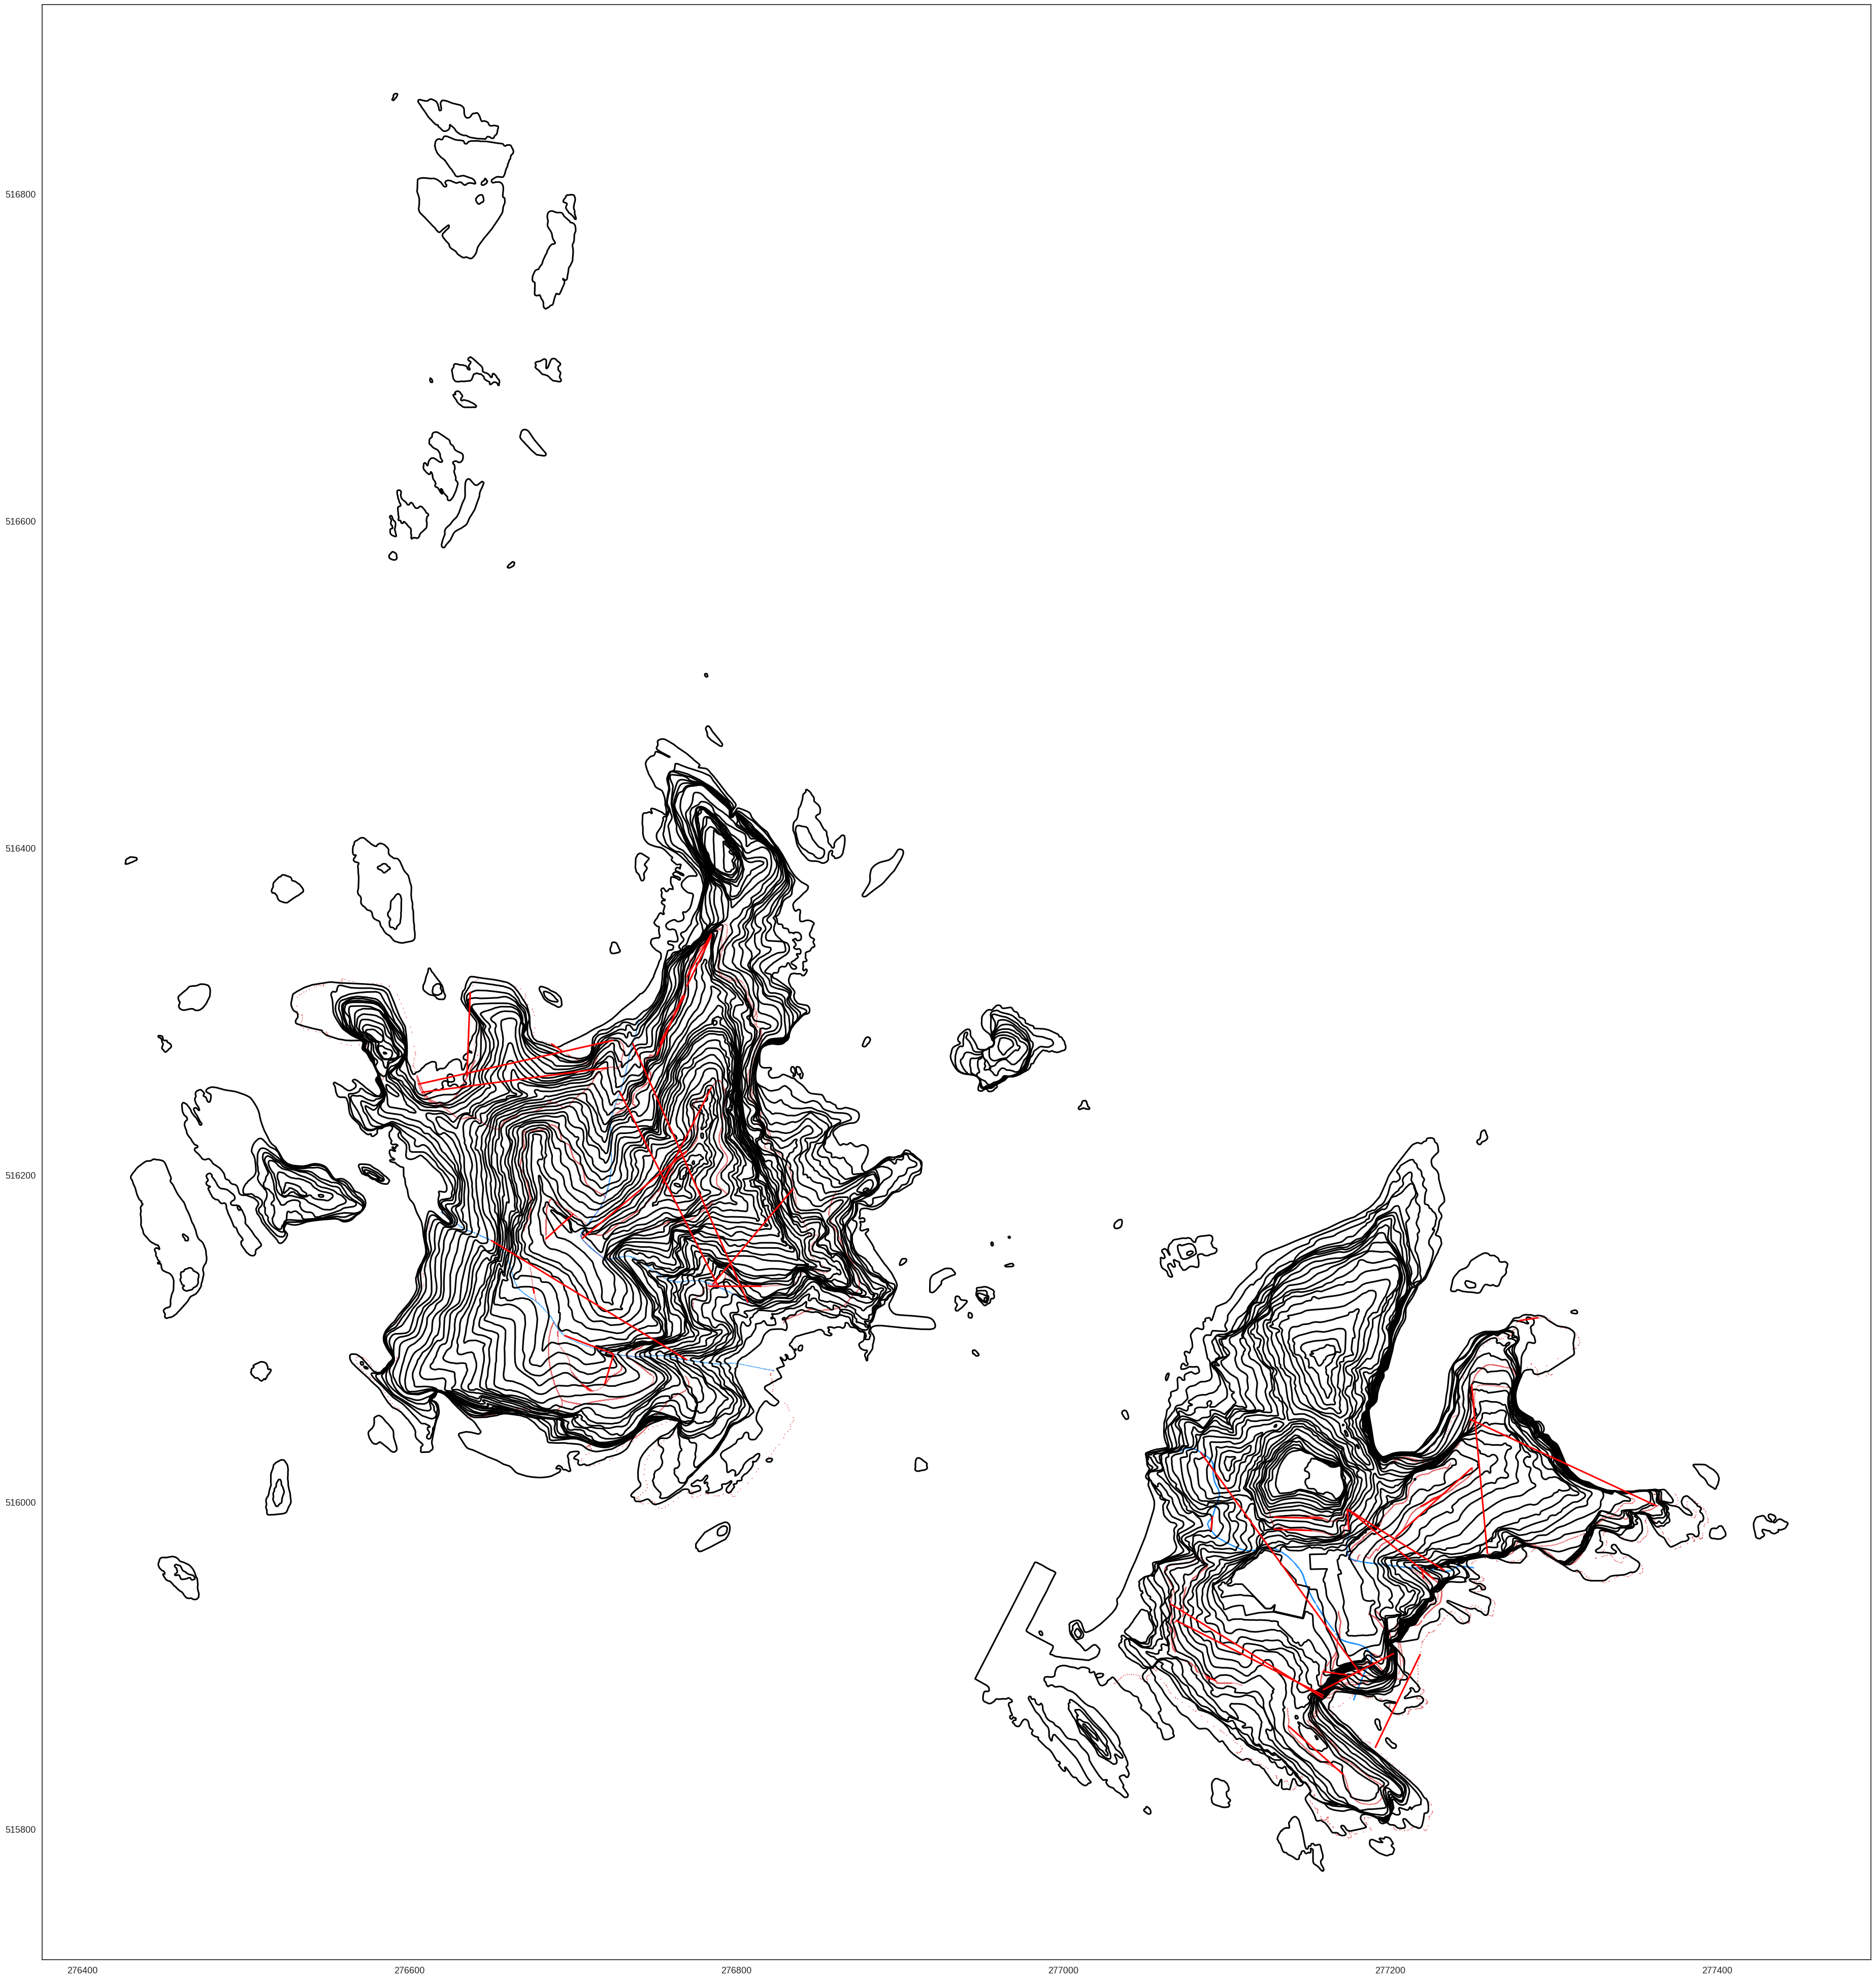

In [18]:
fix, ax = plt.subplots(1, figsize=(50, 50))
EMD.plot(ax=ax, aspect='equal', color='black', markersize=1)
GEO.plot(ax=ax, aspect='equal', color='#e35f62', markersize=1)
FAULT.plot(ax=ax, aspect='equal', color='dodgerblue', markersize=1)
strike.plot(ax=ax, aspect='equal', color='red', markersize=3)

In [19]:
def calculate_distance_linestrings(ls1: shapely.geometry.linestring.LineString,
                                   ls2: shapely.geometry.linestring.LineString) -> float:
    distance = ls1.distance(ls2)
    return distance

def calculate_midpoint_linestring(linestring: shapely.geometry.linestring.LineString) -> shapely.geometry.point.Point:
    substr = ops.substring(geom=linestring,
                           start_dist=0.5,
                           end_dist=linestring.length,
                           normalized=True)

    point = geometry.Point(substr.coords[0])

    return point

def calculate_midpoints_linestrings(linestring_gdf: Union[gpd.geodataframe.GeoDataFrame,
                                                          List[shapely.geometry.linestring.LineString]]) -> \
        List[shapely.geometry.point.Point]:

    # geometry 데이터를 gdf안에 넣어줌
    if isinstance(linestring_gdf, gpd.geodataframe.GeoDataFrame):
        linestring_gdf = linestring_gdf.geometry.tolist()

    # 중앙 점을 계산하여 반환
    midpoints = [calculate_midpoint_linestring(linestring=i) for i in linestring_gdf]

    return midpoints

def calculate_orientations_from_strike_lines(gdf: gpd.geodataframe.GeoDataFrame) -> gpd.geodataframe.GeoDataFrame:
    # 받은 주향선 데이터 프레임을 고도 값으로 정렬한다.
    gdf = gdf.sort_values(by='Z', ascending=True).reset_index(drop=True)
    distances = [calculate_distance_linestrings(ls1=gdf.loc[i].geometry,
                                                ls2=gdf.loc[i + 1].geometry) for i in range(len(gdf) - 1)]
    midpoints = calculate_midpoints_linestrings(linestring_gdf=gdf)
    linestrings_new = [shapely.geometry.LineString([midpoints[i], midpoints[i + 1]]) for i in range(len(midpoints) - 1)]
    orientations_locations = calculate_midpoints_linestrings(linestring_gdf=linestrings_new)

    # 주향선을 통해 해당 면의 깊이, 위치를 구한다.
    dips = np.abs(
        [np.rad2deg(np.arctan((gdf.loc[i + 1]['Z'] - gdf.loc[i]['Z']) / distances[i])) for i in range(len(gdf) - 1)])

    altitudes = [(gdf.loc[i + 1]['Z'] + gdf.loc[i]['Z']) / 2 for i in range(len(gdf) - 1)]

    gdf_new = gg.vector.extract_xy(gdf=gdf,
                         drop_id=False,
                         reset_index=False)

    azimuths = []

    # 면의 각도를 구한다
    for i in range(len(gdf_new['id'].unique()) - 1):
        gdf_new1 = gdf_new[gdf_new['id'] == i + 1 + (gdf_new['id'].unique()[0] - 1)]
        gdf_new2 = gdf_new[gdf_new['id'] == i + 2 + (gdf_new['id'].unique()[0] - 1)]

        gdf_new1_array = gdf_new1[['X', 'Y', 'Z']].values.tolist()
        gdf_new2_array = gdf_new2[['X', 'Y', 'Z']].values.tolist()

        points = gdf_new1_array + gdf_new2_array

        c = np.cov(points, rowvar=False)
        normal_vector = np.linalg.eigh(c)[1][:, 0]
        x, y, z = normal_vector

        sign_z = 1 if z > 0 else -1
        azimuth = (np.degrees(np.arctan2(sign_z * x, sign_z * y)) % 360)

        azimuths.append(azimuth)

    gdf_orient = gpd.GeoDataFrame(data=pd.DataFrame(list(zip(dips, azimuths, altitudes))),
                                  geometry=orientations_locations,
                                  crs=gdf.crs)

    gdf_orient.columns = ['dip', 'azimuth', 'Z', 'geometry']

    gdf_orient['polarity'] = 1
    gdf_orient = gdf_orient.join(other=gdf.drop(labels=['geometry', 'Z'], axis=1).drop(gdf.tail(1).index))
    gdf_orient =  gg.vector.extract_xy(gdf=gdf_orient,
                            reset_index=True)

    return gdf_orient

In [20]:
# 주향선을 이용하여 각 단층면, 지층경계면의 깊이와 각도, 위치를 저장한다.

orientation = calculate_orientations_from_strike_lines(gdf=strike[strike['formation'] == '42'])
orientation = orientation.drop(orientation.index[:], axis=0)
GEO_orientation = orientation.copy()
FAULT_orientation = orientation.copy()

strike_formation_list = strike['formation'].unique()

for i in strike_formation_list:
  temp_orientation = calculate_orientations_from_strike_lines(gdf=strike[strike['formation'] == i])
  if (temp_orientation['type'].unique()[0] == '단층') or (temp_orientation['type'].unique()[0] == '추정단층'):
    FAULT_orientation = pd.concat([FAULT_orientation, temp_orientation]).reset_index(drop=True)
  else:
    GEO_orientation = pd.concat([GEO_orientation, temp_orientation]).reset_index(drop=True)


GEO_orientation['formation'] = GEO_orientation['fid'].astype(str)
GEO_orientation['id'] = GEO_orientation['num'].astype(str)
print(GEO_orientation)

orientation = pd.concat([FAULT_orientation, GEO_orientation]).reset_index(drop=True)


for i in range(len(orientation)):
  dip = orientation.loc[i, 'dip']
  azimuth = orientation.loc[i, 'azimuth']
  formation = orientation.loc[i, 'formation']
  print(f"{formation} dip = {dip:.2f}, azimuth = {azimuth:.2f}")

<ipython-input-19-187700d412b1>:40: RuntimeWarning: divide by zero encountered in scalar divide
  [np.rad2deg(np.arctan((gdf.loc[i + 1]['Z'] - gdf.loc[i]['Z']) / distances[i])) for i in range(len(gdf) - 1)])
<ipython-input-19-187700d412b1>:40: RuntimeWarning: divide by zero encountered in scalar divide
  [np.rad2deg(np.arctan((gdf.loc[i + 1]['Z'] - gdf.loc[i]['Z']) / distances[i])) for i in range(len(gdf) - 1)])
<ipython-input-19-187700d412b1>:40: RuntimeWarning: divide by zero encountered in scalar divide
  [np.rad2deg(np.arctan((gdf.loc[i + 1]['Z'] - gdf.loc[i]['Z']) / distances[i])) for i in range(len(gdf) - 1)])


     dip  azimuth      Z                       geometry  polarity  fid_1   
0  86.11   130.05  52.50  POINT (276804.741 516147.005)      1.00   2282  \
1  90.00     0.00 127.50  POINT (276753.867 516206.017)      1.00   2291   
2  77.63   115.96  27.50  POINT (276769.159 516312.915)      1.00   2362   
3   4.04    76.72  47.50  POINT (277180.190 515969.536)      1.00   1861   
4  21.51    92.21  15.00  POINT (276663.271 516281.896)      1.00   2316   
5  34.50    26.94  12.50  POINT (277102.331 515898.192)      1.00   1871   
6  86.23     0.00  60.00  POINT (277173.431 515895.654)      1.00   1835   
7   1.35   115.74   7.50  POINT (277244.728 515994.978)      1.00   1963   
8  44.25    31.63  17.50  POINT (277133.357 515878.548)      1.00   1869   
9  17.43    39.09  47.50  POINT (277172.005 515982.260)      1.00   1938   
10 90.00    24.92  40.00  POINT (277280.243 516022.088)      1.00   1960   
11 90.00   317.85  82.50  POINT (277226.443 516000.457)      1.00   1987   
12 44.50    

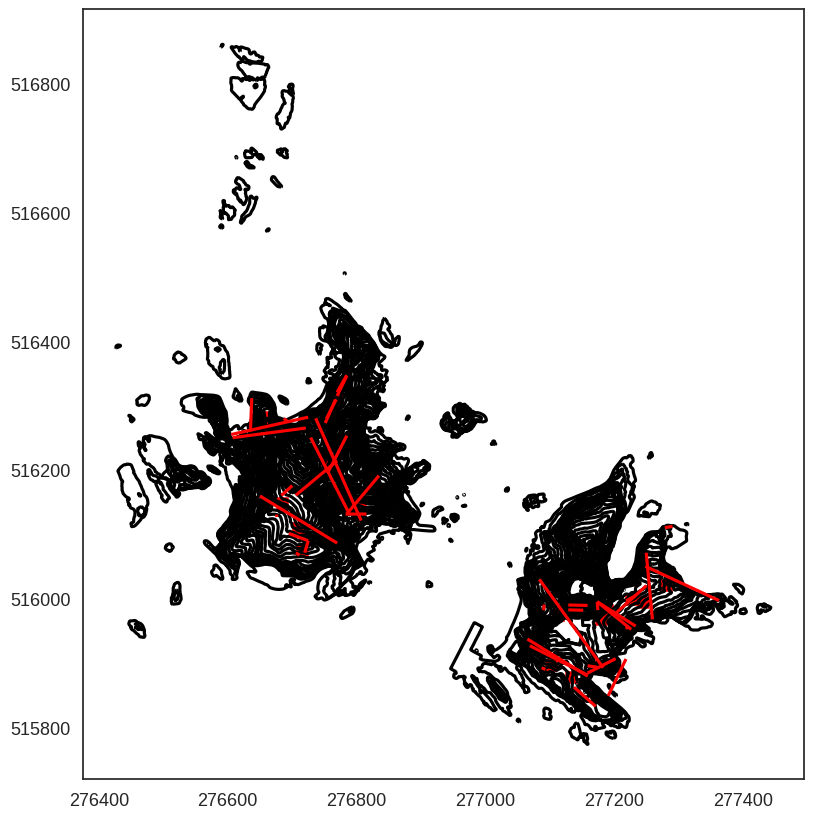

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))

EMD.plot(ax=ax, aspect="equal", color="black", marker=1)

for i in strike_formation_list:
  strike[strike['formation'] == i].plot(ax=ax, aspect="equal", color="red")

for i in range(len(orientation)):
  orientation.loc[i:i].plot(ax=ax, aspect="equal", color="red", marker="s")


In [22]:
geo_model = gp.create_model('model1')

In [23]:
for i in range(len(contacts)):
  if contacts.loc[i, 'type'] != '단층':
    contacts.loc[i, 'formation'] = str(contacts.loc[i, 'fid'])
    contacts.loc[i, 'id'] = str(contacts.loc[i, 'num'])

print(contacts)

    fid_1 mapidx mapname lithoidx  comt   type                       geometry   
0      42   KG31      독도      NaN  None     단층  POINT (277091.412 515991.247)  \
1      42   KG31      독도      NaN  None     단층  POINT (277090.479 515982.531)   
2      42   KG31      독도      NaN  None     단층  POINT (277183.130 515893.168)   
3      42   KG31      독도      NaN  None     단층  POINT (277084.007 516030.414)   
4      23   KG31      독도      NaN  None     단층  POINT (277233.398 515957.937)   
5      23   KG31      독도      NaN  None     단층  POINT (277173.779 515995.646)   
6      23   KG31      독도      NaN  None     단층  POINT (277174.768 515982.686)   
7      23   KG31      독도      NaN  None     단층  POINT (277173.807 515995.410)   
8      51   KG31      독도      NaN  None     단층  POINT (276769.960 516086.738)   
9      51   KG31      독도      NaN  None     단층  POINT (276649.993 516159.983)   
10     51   KG31      독도      NaN  None     단층  POINT (276724.792 516090.492)   
11     51   KG31      독도    

In [24]:
gp.init_data(geo_model, [min_x, max_x, min_y, max_y, 0, 200], [200, 200, 200],
             surface_points_df=contacts,
             orientations_df=orientation, default_values=True)

Active grids: ['regular']


model1  2024-06-05 05:13

In [25]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,42,Default series,1,#015482,1
1,23,Default series,2,#9f0052,2
2,51,Default series,3,#ffbe00,3
3,53,Default series,4,#728f02,4
4,Qst2,Default series,5,#443988,5
5,Qta3,Default series,6,#ff3f20,6
6,Qta2,Default series,7,#5DA629,7
7,Qt,Default series,8,#4878d0,8
8,Qet,Default series,9,#ee854a,9
9,Qdt,Default series,10,#6acc64,10


In [26]:
# temp_cnt = 1
# for i in FAULT_strike_points['formation'].unique():
#   print(f'"Fault{temp_cnt}": (\'{i}\'),', end=' ')
#   temp_cnt += 1

# print('"Strata": (', end='')
# for i in GEO_strike_points['formation'].unique():
#   print(f'"{i}", ', end='')
# print('"L"),', end='')


In [27]:
geo_model.add_surfaces('Qta1')

gp.map_stack_to_surfaces(geo_model,{"Fault1": ('51'), "Fault2": ('53'), "Fault3": ('42'), "Fault4": ('23'), "Strata1": ("Qta1", "Qta3", "Qta2", "Qst2", "Qst1", "Qet", "Qdt", "Qt"),},
                         remove_unused_series=True)

geo_model.set_is_fault(["Fault1"])
geo_model.set_is_fault(["Fault2"])
geo_model.set_is_fault(["Fault3"])
geo_model.set_is_fault(["Fault4"])

Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.
Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Fault1,1,Fault,True,True,False
Fault2,2,Fault,True,True,False
Fault3,3,Fault,True,True,False
Fault4,4,Fault,True,True,False
Strata1,5,Erosion,True,False,False


In [28]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id,No. of Interfaces,No. of Orientations
2,51,Fault1,1,False,True,True,True,#527682,NaN,NaN,NaN,1,4,1
3,53,Fault2,1,False,True,True,True,#527682,NaN,NaN,NaN,2,4,1
0,42,Fault3,1,False,True,True,True,#527682,NaN,NaN,NaN,3,4,1
1,23,Fault4,1,False,True,True,True,#527682,NaN,NaN,NaN,4,4,1
4,Qst2,Strata1,1,False,False,True,True,#443988,NaN,NaN,NaN,5,8,2
5,Qta3,Strata1,2,False,False,True,True,#ff3f20,NaN,NaN,NaN,6,4,1
6,Qta2,Strata1,3,False,False,True,True,#5DA629,NaN,NaN,NaN,7,20,5
7,Qt,Strata1,4,False,False,True,True,#4878d0,NaN,NaN,NaN,8,4,1
8,Qet,Strata1,5,False,False,True,True,#ee854a,NaN,NaN,NaN,9,8,2
9,Qdt,Strata1,6,False,False,True,True,#6acc64,NaN,NaN,NaN,10,4,1


In [29]:
geo_model.set_topography(source="gdal",filepath="raster.tif")

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[2.76428542e+05, 5.15776718e+05, 5.00000000e-01],
       [2.76428542e+05, 5.15776718e+05, 1.50000000e+00],
       [2.76428542e+05, 5.15776718e+05, 2.50000000e+00],
       ...,
       [2.77440507e+05, 5.16848534e+05, 0.00000000e+00],
       [2.77440507e+05, 5.16853521e+05, 0.00000000e+00],
       [2.77440507e+05, 5.16858507e+05, 0.00000000e+00]])

/usr/local/lib/python3.10/dist-packages/gempy/plot/plot_api.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


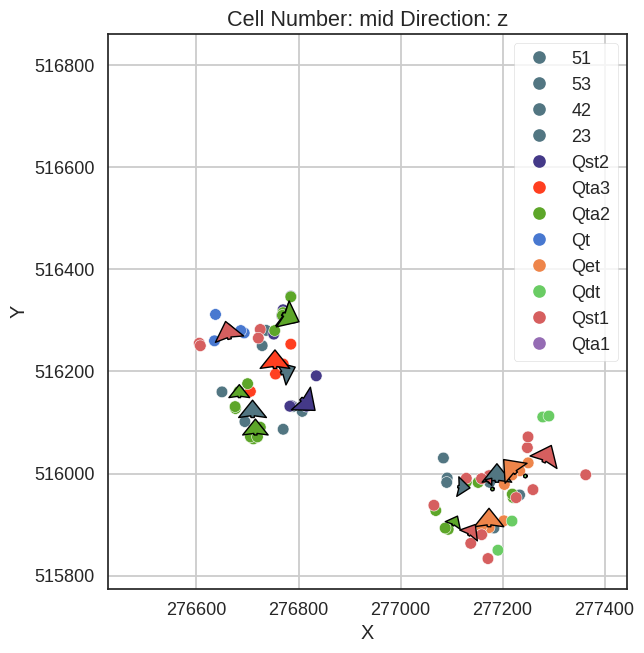

In [30]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

/usr/local/lib/python3.10/dist-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


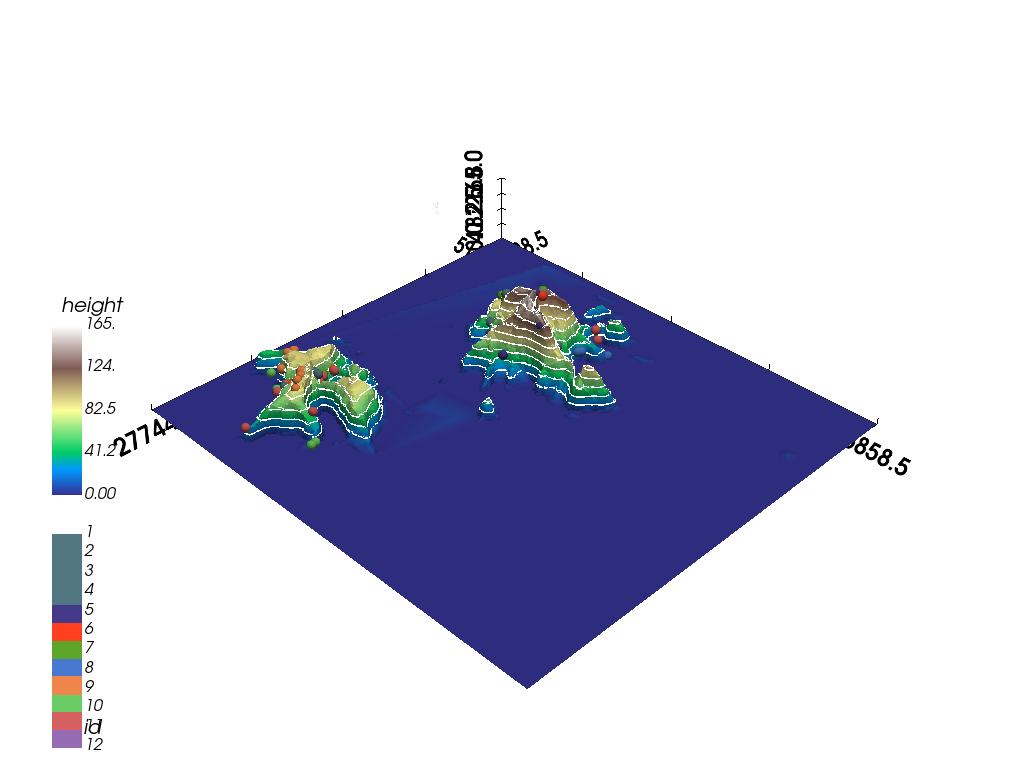

In [31]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True, show_topography=True)

In [32]:
gp.set_interpolator(geo_model, compile_theano=True,
                    theano_optimizer="fast_compile")

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  4
Compilation Done!
Kriging values: 
                           values
range                    1501.95
$C_o$                   53710.90
drift equations  [3, 3, 3, 3, 3]


In [33]:
gp.compute_model(geo_model)


Lithology ids 
  [12. 12. 12. ... 12. 12. 12.] 

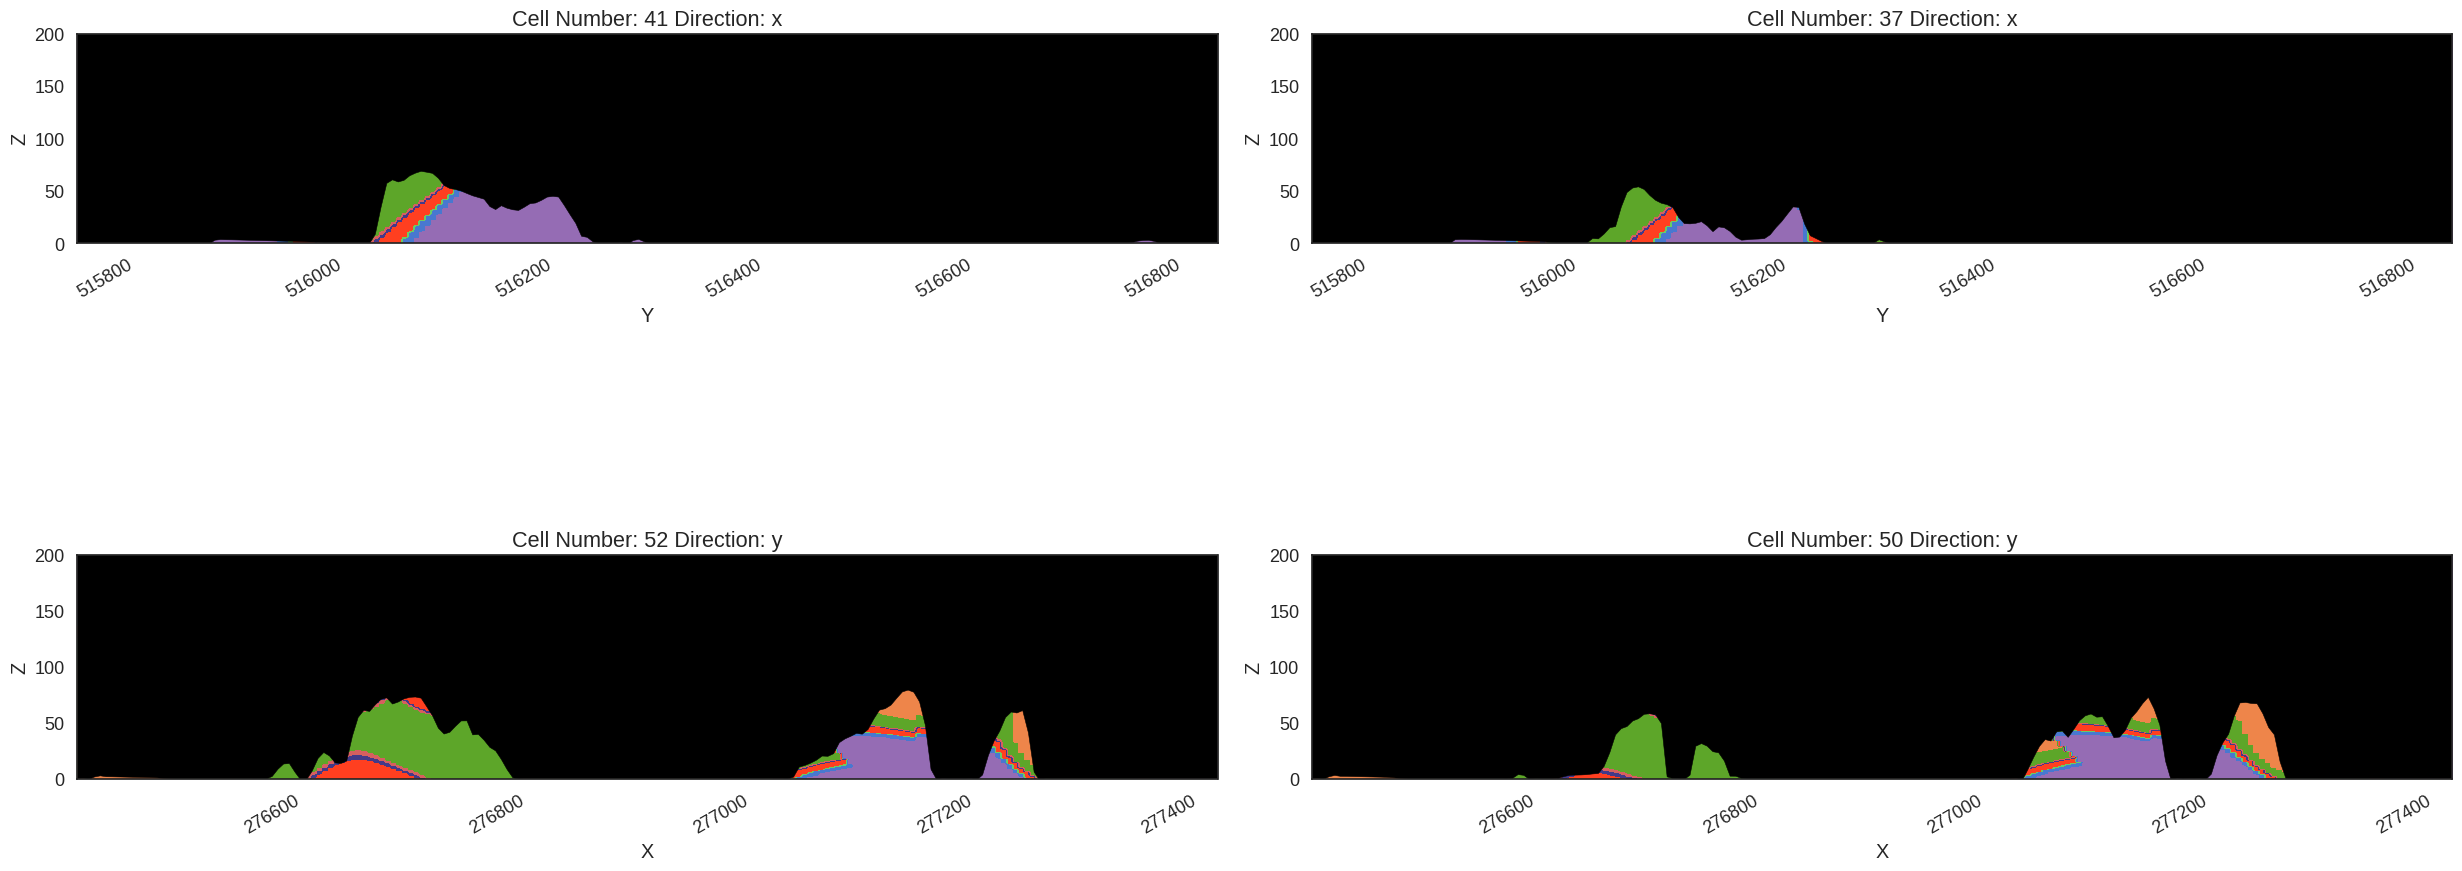

In [48]:
gp.plot_2d(geo_model, direction=["x", "x", "y", "y"], cell_number=[41, 37, 52, 50],
           show_data=False, show_boundaries=False, show_topography=True, show=False);

/usr/local/lib/python3.10/dist-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


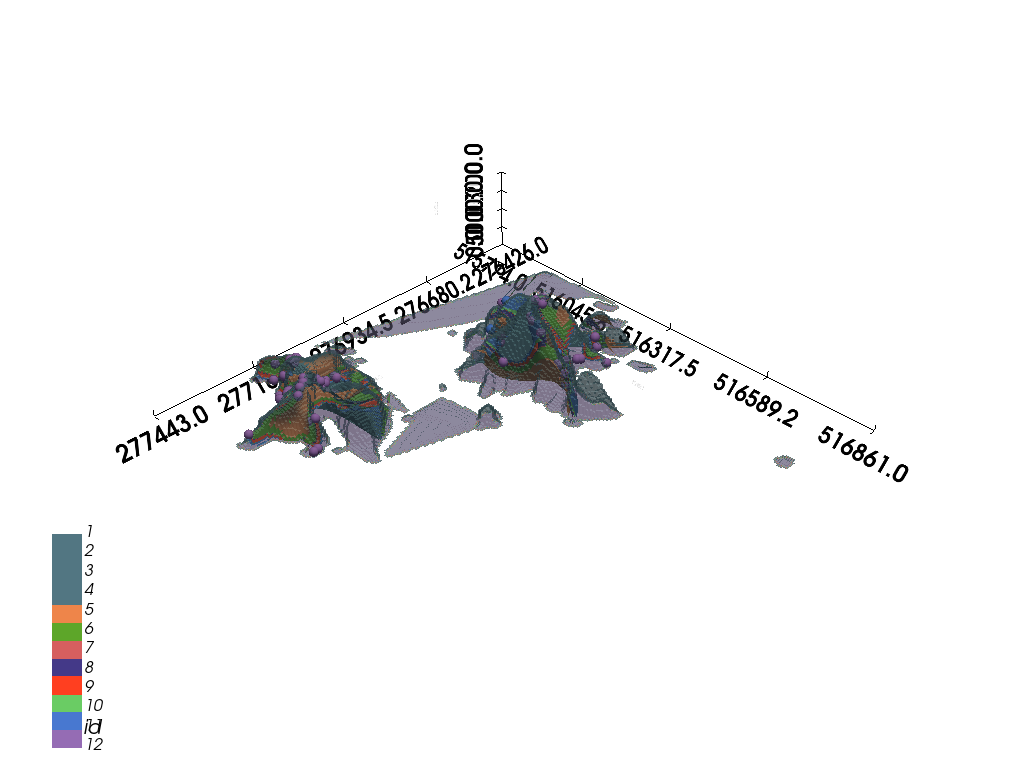

In [35]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=False,
                 plotter_type='basic', notebook=True, show_lith=True)